----------------------------
# Exercise 1.2


In [42]:
# file imports
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.optimize import minimize as minimize
import time
import random
import itertools
import copy
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans

In [3]:
# splitting data in train test and val set
def data_split(data, val = True):
    
    X = np.array(data.iloc[:,:2])
    y = np.array(data.iloc[:, 2])
    
    # train-val split 100% -> 70% - 30%
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1) 
    
    if val == False:
        return X_train.T, X_val.T, y_train, y_val
    
    else:
    # val-test split 30% -> 15% - 15%
        X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=1)
        return X_train.T, X_test.T, X_val.T, y_train, y_test, y_val


data = pd.read_excel(r'C:\Users\RE-Giorgio\Downloads\dataPoints.xlsx')
random.seed(1696995)
X_train, X_test, X_val, y_train, y_test, y_val = data_split(data)

In [156]:
# common class for shallow neural newtworks with 1 output node
class ShallowNeuralNetwork:
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None):

        self.X = X
        self.y = y
        self.N = N
        self.c = self.X.T[np.random.randint(self.X.shape[1], size=self.N),:]
        self.v = np.random.normal(0,1,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.X.shape[0], self.N), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(2)]))
        c, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(2)]
        return c, v
    
    # objective function to minimize
    def loss(self,params):
        
        c, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, c, v) - self.y))) +\
            self.rho*np.square(np.linalg.norm(params))
    
    # metric for train and test accuracy
    def mse(self, X, y, c, v):
        return np.mean(np.square(self.predict(X, c, v) - y)) 

In [157]:
# Mlp inherits the general charectiristics of a shallow nn 
class Rbf(ShallowNeuralNetwork):
    
    # activation function (hyperbolic tangent)
    def phi(self, x, c):
        
        phi = np.exp(-np.square(np.array([np.linalg.norm(arr, axis = 1) for arr in (np.stack([x.T]*self.N) - np.split(c.T, self.N))])/self.sigma))

        return phi
    
    def predict(self, x, c, v):

        H = self.phi(x, c)
        self.output = v @ H
        return self.output

    
                          
    # optimization of the objective function
    def optimize(self):
        
        inits = np.concatenate([array.reshape(-1) for array in [self.c, self.v]])
        
        print("training...", "\n")
        start = time.time()
        result =  minimize(self.loss, x0 = inits, method = self.method)#, jac = self.grad)
        time_elapsed = time.time() - start
        print(result)
        print("finished training.")
        
        # optimal parameters
        self.c, self.v = self.separate(result.x)
        
        return result.nfev, result.njev, result.nit, result.fun, result.jac, time_elapsed

In [160]:
nn = Rbf(X_train, y_train, N = 35, sigma = 0.5, rho = 10e-5, method = "BFGS")
nfev, njev, nit, fun, jac, time_elapsed = nn.optimize()
print("Training Error :", nn.mse(X_train, y_train, nn.c, nn.v))
print("Test Error :", nn.mse(X_test, y_test, nn.c, nn.v)) # 0.0446159739248811

training... 

      fun: 0.023132859384422493
 hess_inv: array([[ 6.93406623e+00, -1.74463029e+00, -2.15603232e-02, ...,
         8.56064196e+00, -2.86344854e+00, -4.60880031e+00],
       [-1.74463029e+00,  1.09171808e+02,  4.23641700e+01, ...,
        -7.07080593e+00, -2.91422920e+01,  6.05368812e+01],
       [-2.15603232e-02,  4.23641700e+01,  1.05371798e+02, ...,
         2.51443430e+01, -5.85172856e+01,  8.08446034e+01],
       ...,
       [ 8.56064196e+00, -7.07080593e+00,  2.51443430e+01, ...,
         5.89676606e+01, -3.14857014e+01, -3.02798816e+01],
       [-2.86344854e+00, -2.91422920e+01, -5.85172856e+01, ...,
        -3.14857014e+01,  7.32357821e+01, -3.73588709e+01],
       [-4.60880031e+00,  6.05368812e+01,  8.08446034e+01, ...,
        -3.02798816e+01, -3.73588709e+01,  4.80584984e+02]])
      jac: array([-6.75558113e-06,  3.47662717e-06,  3.66428867e-06,  2.86661088e-06,
        2.53319740e-06,  2.75275670e-06, -3.81143764e-06, -2.00839713e-06,
        5.55394217e-06,  

In [161]:
def plot(nn):
    
    # creates 3d space
    fig = plt.figure()
    ax = Axes3D(fig)
    
    # grid of the support of the estimated function
    x1 = np.linspace(-1, 1, 200)
    x2 = np.linspace(-2, 2, 200)
    X1, X2 = np.meshgrid(x1, x2)
    
    # predictions on the given support
    Y = np.array([nn.predict(np.array([x1[i], x2[k]]).reshape(2,1),
                             nn.c, nn.v) for i in range(200) for k in range(200)])
    Y = Y.ravel().reshape(200,200)
    
    # plotting
    ax.plot_surface(X1, X2, Y, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

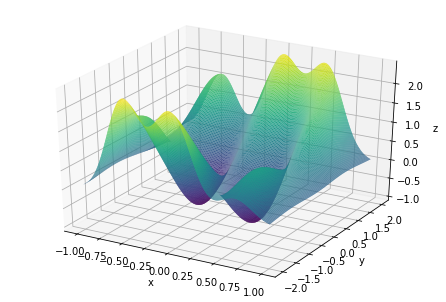

In [162]:
plot(nn)

---------------
# Exercise 2.2

In [163]:
# common class for shallow neural newtworks with 1 output node
class ShallowNeuralNetwork:
    
    
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None):
        
         # clustering
        def pick_clusters(X, N):
            km = KMeans(n_clusters=N, init = "k-means++").fit(X.T)
            return km.cluster_centers_.T

        self.X = X
        self.y = y
        self.N = N
        self.c = pick_clusters(X, N)
        self.v = np.random.normal(0,1,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method
        


    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.X.shape[0], self.N), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(2)]))
        c, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(2)]
        return c, v
    
    # objective function to minimize
    def loss(self,params):
        
        c, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, c, v) - self.y))) +\
            self.rho*np.square(np.linalg.norm(params))
    
    # metric for train and test accuracy
    def mse(self, X, y, c, v):
        return np.mean(np.square(self.predict(X, c, v) - y)) 

In [164]:
# Mlp inherits the general charectiristics of a shallow nn 
class Rbf_el(ShallowNeuralNetwork):
    
    # activation function (hyperbolic tangent)
    def phi(self, x, c):
        
        phi = np.exp(-np.square(np.array([np.linalg.norm(arr, axis = 1) for arr in (np.stack([x.T]*self.N) - np.split(c.T, self.N))])/self.sigma))

        return phi
    
    def predict(self, x, c, v):

        H = self.phi(x, c)
        self.output = v @ H
        return self.output

    
                          
    # optimization of the objective function
    def optimize(self):
        
        H = self.phi(self.X, self.c)
        clf =  Ridge(alpha = self.rho)
        clf.fit(H.T, self.y)
        
        self.v = clf.coef_

In [228]:
# extreme  learning traning
print("training...", "\n")
start = time.time()
test_mse = 100
while test_mse > 3:
    nn = Rbf_el(X_train, y_train, N = 20, sigma = 0.1, rho = 10e-5)
    nn.optimize()
    test_mse = nn.mse(X_test, y_test, nn.c, nn.v)
    
time_elapsed = time.time() - start
print("finished training.")
        
print("Train Error :", nn.mse(X_train, y_train, nn.c, nn.v))
print("Test Error :", nn.mse(X_test, y_test, nn.c, nn.v))

training... 

finished training.
Train Error : 2.421184943027063
Test Error : 2.8481345692050533


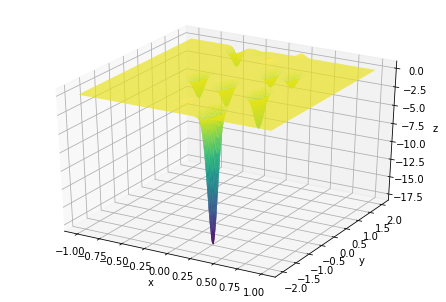

In [229]:
plot(nn)